This notebook loads data stored in text files, formats and stored into pandas dataframes. Some additional producs are computed and stored in dataframes, including uncertainty band and chl anomaly. The dataframes are then pickled for plotting in a later notebook.

In [1]:
import pandas as pd
import pathlib
from datetime import datetime
import pickle
from scipy.stats import mode
import numpy as np
from IPython.core.display import HTML, display
import matplotlib.pyplot as pl
from matplotlib import rcParams
import pymc3 as pm

In [2]:
%matplotlib inline

In [97]:
def convert_secs2dt(sec):
    """
    Converts seconds to python datetime object.
    :param sec 
    :return: datetime object
    """
    zd00 = datetime(2000, 1, 1)
    zd70 = datetime(1970, 1, 1)
    offset = (zd00 - zd70).total_seconds()
    z = datetime.utcfromtimestamp(sec + offset)
    return z


def get_doy(secs):
    """
    Converts seconds to fractional day of year.
    :param secs
    :return: fractional day of year 
    """
    z = convert_secs2dt(secs)
    y = z.year
    return (secs + (datetime(2000, 1, 1) - datetime(y, 1, 1)).total_seconds()) / 86400


def load_format_data(filepath, minimal=True, columns=None, quantity='chl_a'):
    """
    Loads chlorophyll data into a pandas dataframe,
    formats time entries, and creates a datetime index.
    :param filepath: string or pathlib object  
    :param minimal: if True returns only chl_a_mean; drops the rest.
    :return: pandas datetime indexed dataframe
    """
    if columns is None:
        columns = ['time', 'nbins', 'mean', 'median', 'stdv']
    
    df = pd.read_csv(filepath, delim_whitespace=True, names=columns)
    df['datetime'] = df.time.apply(convert_secs2dt)
    df.set_index('datetime', inplace=True)
    if minimal:
        df = df[['mean']]
    df.rename(columns={'mean': '%s_mean' % quantity}, inplace=True)
    return df


def regress_phyto_c(df, mean_col_label='bbp_443_giop_mean',
                   reg_slope=12128, reg_bias=0.59):
    df['phyto_c'] = df[mean_col_label] * reg_slope + reg_bias
    return df


def get_monthly_means(df, **kwargs):
    """
    Groups data by month and compute annual cycle based on monthly means.
    :param df: 
        datetime indexed pandas dataframe
    :param kwargs:
        year_start (optional): string, slice start
        year_end (optional): string, slice end
    :return: 
        month-indexed pandas dataframe with monthly means
    """
    year_start = kwargs.pop('year_start', df.index.year[0])
    year_end = kwargs.pop('year_end', df.index.year[-1])
    return df.loc[str(year_start): str(year_end)].groupby(lambda x: x.month).aggregate('mean')


def get_anomaly(df, df_ann_cycle, name='chl_a_mean', anomaly_name='anomaly'):
    """
    Computes annomaly by removing monthly mean for a given month
    :param df:
        pandas dataframe with [name] parameter column
    :param df_ann_cycle:
        pandas dataframe of length 12 containing monthly means
    :param name:
        str, label of quantity to get anomaly from
    :return:
        None
    """

    for month in df_ann_cycle.index:
        idx = df.index.month == month
        df.loc[idx, anomaly_name] = df.loc[idx, name] - df_ann_cycle.loc[month, name]


def test(datadir):
    testfile = datadir / 'ar2018.0m_AtlN55_chlor_a.txt'
    df_test = load_format_data(testfile, minimal=False)
    t0 = df_test.time[0]    
    z0 = convert_secs2dt(t0)
    zstr0 = z0.strftime('%Y%j%H%M%S')
    try:
        assert zstr0 + '000' == str(2002197194740000)
    except AssertionError as e:
        print(e)
        print(zstr0)
    assert z0.year == 2002
    doy0 = get_doy(t0)
    assert doy0 == 196.82476851851851
    tl = df_test.tail(1).time.values
    zl = convert_secs2dt(tl)
    zstrl = zl.strftime('%Y%j%H%M%S')
    assert zstrl + '000' == str(2016321013320000)
    assert zl.year == 2016
    doyl = get_doy(tl)
    assert doyl == 320.06481481481484
    print("all tests passed")

In [98]:
# Global graphics setup
display(HTML("<style>.container {width: 90%}</style>"))
plot_colors = {'swf': '#000000',
               'aqua': '#348ABD',
               'viirs': '#A60628',
               'mei': '#467821',
               }
rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['font.size'] = 15
rcParams['ytick.major.size'] = 8
rcParams['ytick.minor.size'] = 3
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 3
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.direction'] = 'in'

In [99]:
# Paths
home = pathlib.Path.home()
dataMain = home / 'DEV-ALL/State_of_the_Climate/soc2018/TIMESERIES/'
aquaIOPdir = dataMain / 'ar2018.0IOPm_ar2018.0IOPm/stats'
swfIOPdir = dataMain / 'sr2018.0IOPm_sr2018.0IOPm/stats'
viirsIOPdir = dataMain / 'vr2018.0IOPm_vr2018.0IOPm/stats'
fp_bbp_443_giop_aqua = aquaIOPdir / 'ar2018.0IOPm_eqsst_bbp_443_giop.txt'
fp_bbp_443_giop_swf = swfIOPdir / 'sr2018.0IOPm_eqsst_bbp_443_giop.txt'
fp_bbp_443_giop_viirs = viirsIOPdir / 'vr2018.0IOPm_eqsst_bbp_443_giop.txt'
#test(test_aquadir)

In [100]:
df_swf_bbp = load_format_data(fp_bbp_443_giop_swf, quantity='bbp_443_giop')
df_aqua_bbp = load_format_data(fp_bbp_443_giop_aqua, quantity='bbp_443_giop')
df_viirs_bbp = load_format_data(fp_bbp_443_giop_viirs, quantity='bbp_443_giop')

In [101]:
df_bb_nomad = pd.read_pickle('../../../TOA_ML/pickleJar/DevelopmentalDataSets/df_2_bb.pkl')

In [102]:
df_bb_nomad.replace(to_replace=-999.0, value=np.NAN, inplace=True)

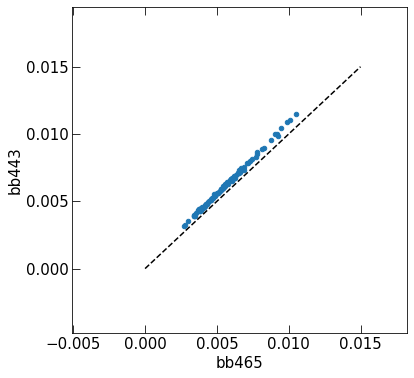

In [9]:
_, ax = pl.subplots(figsize=(6, 6))
df_bb_nomad.plot(x='bb465', y='bb443', kind='scatter', ax=ax)
ax.plot([0, 0.015],[0, 0.015], ls='--', color='k');

In [10]:
Xy = df_bb_nomad[['bb465', 'bb443']].dropna()

In [11]:
with pm.Model() as m:
    intercept = pm.Normal('intercept', 0, sd=1)
    slope = pm.Normal('slope', 0, sd=1)
    sigma_ = pm.HalfCauchy('sigma', 5)
    mu_ = intercept + slope * Xy.bb465.values
    likelihood = pm.Normal('likelihood', mu=mu_, sd=sigma_, observed=Xy.bb443.values)

In [12]:
with m:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1058.85draws/s]
The acceptance probability does not match the target. It is 0.9561171312842445, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9654356632660664, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9439971891803534, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9572882346755826, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


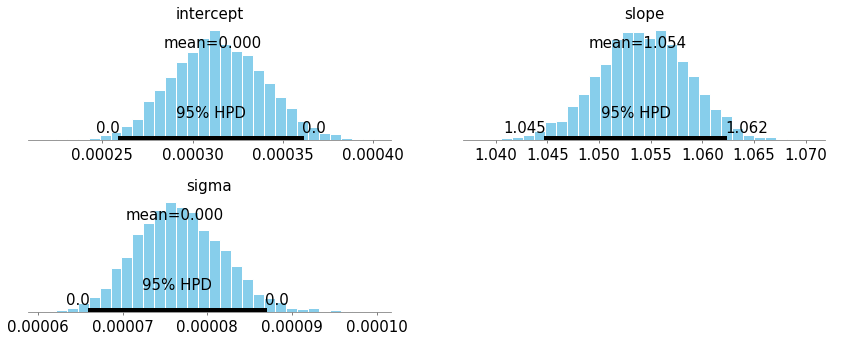

In [13]:
pm.plot_posterior(trace);

In [67]:
with open('./pklJar/pooled_params.pkl', 'rb') as fb:
    pooled_params_dict = pickle.load(fb)

In [68]:
slope = pooled_params_dict['slope']

In [69]:
slope = slope.reshape(-1, 1)

In [70]:
intercept = pooled_params_dict['intercept']

In [71]:
intercept = intercept.reshape(-1, 1)

In [103]:
def compute_phyto_C_stats(df_):
    bbp_443_ = df_.bbp_443_giop_mean.values.reshape(1,-1)
    phyto_c_trace_ = intercept + bbp_443_ * slope
    phyto_c_mean = phyto_c_trace_.mean(axis=0)
    phyto_c_hpd = pm.hpd(phyto_c_trace_)
    df_.insert(loc=1, column='phyto_C_2.5%', value=phyto_c_hpd[:, 0])
    df_.insert(loc=2, column='phyto_C_97.5%', value=phyto_c_hpd[:, 1])
    df_.insert(loc=2, column='phyto_C_mean', value=phyto_c_mean)

In [104]:
compute_phyto_C_stats(df_aqua_bbp)

In [105]:
compute_phyto_C_stats(df_swf_bbp)

In [106]:
df_aqua_bbp.head()

,bbp_443_giop_mean,phyto_C_2.5%,phyto_C_mean,phyto_C_97.5%
datetime,,,,
2002-07-16 22:10:00,0.001823,20.197499,21.901264,23.794579
2002-08-19 09:03:30,0.001815,20.084285,21.801759,23.661935
2002-09-16 01:52:30,0.001882,20.848132,22.597096,24.574319
2002-10-16 13:17:30,0.001882,20.842028,22.594274,24.567595
2002-11-16 01:15:00,0.001899,21.004253,22.792814,24.764797


In [109]:
df_aqua_bbp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194 entries, 2002-07-16 22:10:00 to 2018-08-16 13:43:20
Data columns (total 4 columns):
bbp_443_giop_mean    194 non-null float64
phyto_C_2.5%         194 non-null float64
phyto_C_mean         194 non-null float64
phyto_C_97.5%        194 non-null float64
dtypes: float64(4)
memory usage: 7.6 KB


In [108]:
df_aqua_bbp.resample('M').first().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194 entries, 2002-07-31 to 2018-08-31
Freq: M
Data columns (total 4 columns):
bbp_443_giop_mean    194 non-null float64
phyto_C_2.5%         194 non-null float64
phyto_C_mean         194 non-null float64
phyto_C_97.5%        194 non-null float64
dtypes: float64(4)
memory usage: 7.6 KB


In [110]:
bbp_443_aqua = df_aqua_bbp.bbp_443_giop_mean.values.reshape(1, -1) * slope + intercept
bbp_443_swf = df_swf_bbp.bbp_443_giop_mean.values.reshape(1, -1) * slope + intercept

### How to combine estimates ([*cf this*](https://www.fil.ion.ucl.ac.uk/~wpenny/course/bayes.pdf)):
This type of updating is relevant to the sensor fusion problem, where we have information
about a variable from two different sources and we wish to combine that
information.
Say, for example, we had two estimates for the amount of carbon in a given compound;
method 1 estimates the percentage to be $35 \pm4$ units and method 2 estimates it to be
$40 \pm7$ units. 
Before observing the second result we have a prior belief that the mean
percentage is $x_0 = 35$ and the variance is $4^2 = 16$ which corresponds to a precision
of $\beta_0 = 0.0625$. Whilst the first result is viewed as the prior, the second result is
viewed as the 'data', which has mean $y = 40$ and precision $\beta_D = 1/7^2 = 0.0204$. Our
posterior estimate for the amount of carbon is then estimated as
$$m = \frac{0.0625}{0.0829} \times 35 + \frac{0.0204}{0.0829} \times 40 = 36.2 $$
and the posterior standard deviation is $3.5$. If the results of method 2 were chosen as
the prior (instead of method 1) we'd get the same result.
The equation for the posterior mean can be re-arranged as
$$ m = x_0 + \frac{\beta_D}{\beta}(y - x_0)$$
showing that the new estimate is the old estimate plus some fraction (which may be viewed as a learning rate) of an error term $e = y-x_0$.

In [111]:
bbp_443_aqua_50ci = pm.hpd(bbp_443_aqua, alpha=0.5)
bbp_443_swf_50ci = pm.hpd(bbp_443_swf, alpha=0.5)

In [112]:
df_swf_bbp.head()

,bbp_443_giop_mean,phyto_C_2.5%,phyto_C_mean,phyto_C_97.5%
datetime,,,,
1997-11-15 22:47:10,0.001788,19.804042,21.490657,23.329433
1997-12-16 09:42:30,0.001712,18.924558,20.588875,22.316328
1998-01-16 10:37:10,0.001673,18.483070,20.128751,21.795382
1998-02-14 22:23:00,0.001660,18.353762,19.980316,21.641513
1998-03-16 11:46:40,0.001686,18.609830,20.291182,21.958779


In [113]:
df_swf_bbp.insert(2, 'phyto_C_25%', bbp_443_swf_50ci[:, 0])

In [114]:
df_swf_bbp.insert(4, 'phyto_C_75%', bbp_443_swf_50ci[:, 1])

In [115]:
df_aqua_bbp.insert(2, 'phyto_C_25%', bbp_443_aqua_50ci[:, 0])

In [116]:
df_aqua_bbp.insert(4, 'phyto_C_75%', bbp_443_aqua_50ci[:, 1])

In [117]:
df_swf_bbp.head().T

datetime,1997-11-15 22:47:10,1997-12-16 09:42:30,1998-01-16 10:37:10,1998-02-14 22:23:00,1998-03-16 11:46:40
bbp_443_giop_mean,0.001788,0.001712,0.001673,0.001660,0.001686
phyto_C_2.5%,19.804042,18.924558,18.483070,18.353762,18.609830
phyto_C_25%,20.946457,19.993809,19.562847,19.359291,19.714802
phyto_C_mean,21.490657,20.588875,20.128751,19.980316,20.291182
phyto_C_75%,22.115385,21.110110,20.657379,20.447693,20.818037
phyto_C_97.5%,23.329433,22.316328,21.795382,21.641513,21.958779


In [118]:
df_aqua_bbp.head().T

datetime,2002-07-16 22:10:00,2002-08-19 09:03:30,2002-09-16 01:52:30,2002-10-16 13:17:30,2002-11-16 01:15:00
bbp_443_giop_mean,0.001823,0.001815,0.001882,0.001882,0.001899
phyto_C_2.5%,20.197499,20.084285,20.848132,20.842028,21.004253
phyto_C_25%,21.343615,21.245797,21.968674,21.966110,22.146285
phyto_C_mean,21.901264,21.801759,22.597096,22.594274,22.792814
phyto_C_75%,22.538910,22.434313,23.204997,23.202138,23.393081
phyto_C_97.5%,23.794579,23.661935,24.574319,24.567595,24.764797


In [119]:
# Compute annual cycle and monthly anomalies
aqua_ann_cycle = get_monthly_means(df_aqua_bbp[['phyto_C_mean']],
                                   year_start=2003, year_end=2011)
for dfi in [df_swf_bbp, df_aqua_bbp]:
        get_anomaly(dfi, aqua_ann_cycle, name='phyto_C_mean', anomaly_name='phyto_C_anomaly')

In [204]:
aqua_ann_cycle

,phyto_C_mean
1,21.535771
2,21.165246
3,21.150857
4,21.549036
5,21.710918
6,21.437494
7,20.916025
8,21.142859
9,21.653285
10,22.508804


In [121]:
df_swf_bbp.head()

,bbp_443_giop_mean,phyto_C_2.5%,phyto_C_25%,phyto_C_mean,phyto_C_75%,phyto_C_97.5%,phyto_C_anomaly
datetime,,,,,,,
1997-11-15 22:47:10,0.001788,19.804042,20.946457,21.490657,22.115385,23.329433,-1.488190
1997-12-16 09:42:30,0.001712,18.924558,19.993809,20.588875,21.110110,22.316328,-1.795018
1998-01-16 10:37:10,0.001673,18.483070,19.562847,20.128751,20.657379,21.795382,-1.407020
1998-02-14 22:23:00,0.001660,18.353762,19.359291,19.980316,20.447693,21.641513,-1.184930
1998-03-16 11:46:40,0.001686,18.609830,19.714802,20.291182,20.818037,21.958779,-0.859675


In [122]:
df_aqua_bbp.head()

,bbp_443_giop_mean,phyto_C_2.5%,phyto_C_25%,phyto_C_mean,phyto_C_75%,phyto_C_97.5%,phyto_C_anomaly
datetime,,,,,,,
2002-07-16 22:10:00,0.001823,20.197499,21.343615,21.901264,22.538910,23.794579,0.985239
2002-08-19 09:03:30,0.001815,20.084285,21.245797,21.801759,22.434313,23.661935,0.658900
2002-09-16 01:52:30,0.001882,20.848132,21.968674,22.597096,23.204997,24.574319,0.943811
2002-10-16 13:17:30,0.001882,20.842028,21.966110,22.594274,23.202138,24.567595,0.085470
2002-11-16 01:15:00,0.001899,21.004253,22.146285,22.792814,23.393081,24.764797,-0.186034


In [224]:
# Create a new dataframe to compute and store an "uncertainty" band based on SWF/Aqua overlapping data.
column = 'bbp_443_giop_mean'
df_swf_aqua = pd.concat((df_swf_bbp[[column]], df_aqua_bbp[[column]]), axis=1)
df_swf_aqua.columns=['swf_%s' % column, 'aqua_%s' % column]

In [225]:
df_swf_aqua = df_swf_aqua.resample('MS', loffset=pd.Timedelta(14, 'd')).first().dropna()

In [226]:
df_swf_aqua.head()

,swf_bbp_443_giop_mean,aqua_bbp_443_giop_mean
datetime,,
2002-07-15,0.001632,0.001823
2002-08-15,0.001704,0.001815
2002-09-15,0.001742,0.001882
2002-10-15,0.001741,0.001882
2002-11-15,0.001729,0.001899


In [227]:
df_swf_aqua.dropna(inplace=True)
df_swf_aqua['mean'] = df_swf_aqua.mean(axis=1)
df_swf_aqua['diff'] = np.abs(df_swf_aqua['swf_%s' % column].values - df_swf_aqua['aqua_%s' % column].values)
df_swf_aqua['diff_pos'] = df_swf_aqua['mean'] + df_swf_aqua['diff'].mean()
df_swf_aqua['diff_neg'] = df_swf_aqua['mean'] - df_swf_aqua['diff'].mean()
df_swf_aqua.head()

,swf_bbp_443_giop_mean,aqua_bbp_443_giop_mean,mean,diff,diff_pos,diff_neg
datetime,,,,,,
2002-07-15,0.001632,0.001823,0.001727,0.000192,0.001834,0.001620
2002-08-15,0.001704,0.001815,0.001759,0.000111,0.001866,0.001652
2002-09-15,0.001742,0.001882,0.001812,0.000140,0.001919,0.001705
2002-10-15,0.001741,0.001882,0.001811,0.000141,0.001919,0.001704
2002-11-15,0.001729,0.001899,0.001814,0.000170,0.001921,0.001707


In [228]:
# exclude SeaWiFS 'bad' years
swf_good_per_ends = '2007-12-31'
df_swf_aqua = df_swf_aqua.loc[:swf_good_per_ends, :]
df_swf_bbp = df_swf_bbp.loc[:swf_good_per_ends, :]

In [229]:
df_swf_aqua.head()

,swf_bbp_443_giop_mean,aqua_bbp_443_giop_mean,mean,diff,diff_pos,diff_neg
datetime,,,,,,
2002-07-15,0.001632,0.001823,0.001727,0.000192,0.001834,0.001620
2002-08-15,0.001704,0.001815,0.001759,0.000111,0.001866,0.001652
2002-09-15,0.001742,0.001882,0.001812,0.000140,0.001919,0.001705
2002-10-15,0.001741,0.001882,0.001811,0.000141,0.001919,0.001704
2002-11-15,0.001729,0.001899,0.001814,0.000170,0.001921,0.001707


In [230]:
df_swf_aqua.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66 entries, 2002-07-15 to 2007-12-15
Data columns (total 6 columns):
swf_bbp_443_giop_mean     66 non-null float64
aqua_bbp_443_giop_mean    66 non-null float64
mean                      66 non-null float64
diff                      66 non-null float64
diff_pos                  66 non-null float64
diff_neg                  66 non-null float64
dtypes: float64(6)
memory usage: 3.6 KB


In [231]:
df_swf_bbp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 1997-11-15 22:47:10 to 2007-12-16 10:50:00
Data columns (total 8 columns):
bbp_443_giop_mean        122 non-null float64
phyto_C_2.5%             122 non-null float64
phyto_C_25%              122 non-null float64
phyto_C_mean             122 non-null float64
phyto_C_75%              122 non-null float64
phyto_C_97.5%            122 non-null float64
phyto_C_anomaly          122 non-null float64
bbp_443_aqua_adjusted    122 non-null float64
dtypes: float64(8)
memory usage: 8.6 KB


In [232]:
df_aqua_bbp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194 entries, 2002-07-16 22:10:00 to 2018-08-16 13:43:20
Data columns (total 8 columns):
bbp_443_giop_mean       194 non-null float64
phyto_C_2.5%            194 non-null float64
phyto_C_25%             194 non-null float64
phyto_C_mean            194 non-null float64
phyto_C_75%             194 non-null float64
phyto_C_97.5%           194 non-null float64
phyto_C_anomaly         194 non-null float64
bbp_443_swf_adjusted    194 non-null float64
dtypes: float64(8)
memory usage: 18.6 KB


In [233]:
with open('./pklJar/pooled_params.pkl', 'rb') as fb:
    mdl_dict = pickle.load(fb)

In [234]:
intercept = mdl_dict['intercept'].reshape(1, -1)
slope = mdl_dict['slope'].reshape(1, -1)

In [235]:
swf_adj=(df_swf_aqua['mean'] - df_swf_aqua.swf_bbp_443_giop_mean).mean()

In [236]:
aqua_adj=(df_swf_aqua.aqua_bbp_443_giop_mean - df_swf_aqua['mean']).mean()

In [237]:
swf_adj, aqua_adj

(5.354212121212122e-05, 5.35421212121212e-05)

In [238]:
df_swf_bbp['bbp_443_aqua_adjusted'] = df_swf_bbp.bbp_443_giop_mean + swf_adj

In [239]:
df_aqua_bbp['bbp_443_swf_adjusted'] = df_aqua_bbp.bbp_443_giop_mean - aqua_adj

In [240]:
df_mean = pd.concat((df_swf_bbp.bbp_443_aqua_adjusted.resample('MS', loffset=pd.Timedelta(14, 'd')).first(),
                     df_aqua_bbp.bbp_443_swf_adjusted.resample('MS', loffset=pd.Timedelta(14, 'd')).first()),axis=1
                     )

In [241]:
df_mean.tail()

,bbp_443_aqua_adjusted,bbp_443_swf_adjusted
datetime,,
2018-04-15,NaN,0.001746
2018-05-15,NaN,0.001760
2018-06-15,NaN,0.001744
2018-07-15,NaN,0.001714
2018-08-15,NaN,0.001739


In [242]:
df_mean['mean_adjustd_bbp443'] = df_mean.mean(axis=1)

In [243]:
trace_C_mean_phyto = df_mean.mean_adjustd_bbp443.values.reshape(-1, 1) * slope + intercept

In [244]:
df_mean['adjusted_phyto_C_mean'] = trace_C_mean_phyto.mean(axis=1)

In [245]:
df_mean['adj_C_2.5%'], df_mean['adj_C_97.5%'] = pm.hpd(trace_C_mean_phyto.T)[:, 0], pm.hpd(trace_C_mean_phyto.T)[:, 1]

In [246]:
df_mean.insert(5, 'adj_C_25%', pm.hpd(trace_C_mean_phyto.T, alpha=0.5)[:, 0] )
df_mean.insert(6, 'adj_C_75%', pm.hpd(trace_C_mean_phyto.T, alpha=0.5)[:, 1] )

In [247]:
df_mean.head()

,bbp_443_aqua_adjusted,bbp_443_swf_adjusted,mean_adjustd_bbp443,adjusted_phyto_C_mean,adj_C_2.5%,adj_C_25%,adj_C_75%,adj_C_97.5%
datetime,,,,,,,,
1997-11-15,0.001842,NaN,0.001842,22.120413,20.385325,21.552935,22.762124,24.021646
1997-12-15,0.001765,NaN,0.001765,21.218630,19.559207,20.546520,21.699756,23.046890
1998-01-15,0.001726,NaN,0.001726,20.758506,19.085081,20.162330,21.287907,22.512791
1998-02-15,0.001713,NaN,0.001713,20.610071,18.944551,20.015984,21.132228,22.340050
1998-03-15,0.001740,NaN,0.001740,20.920938,19.345028,20.307371,21.442327,22.798734


In [248]:
trace_C_swf = df_swf_aqua.iloc[:, 0].values.reshape(-1, 1) * slope + intercept
trace_C_aqua = df_swf_aqua.iloc[:, 1].values.reshape(-1, 1) * slope + intercept
trace_C_mean = df_swf_aqua.iloc[:, 2].values.reshape(-1, 1) * slope + intercept

In [249]:
trace_dict = {'swf': trace_C_swf, 
             'aqua': trace_C_aqua,
             'mean': trace_C_mean,
             }
with open('./pklJar/trace.pkl', 'wb') as fb:
    pickle.dump(trace_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [250]:
df_swf_aqua.insert(3, 'mean_phyto_C', trace_C_mean.mean(axis=1))

In [251]:
df_swf_aqua.insert(4, 'mean_minus_swf_C', trace_C_mean.mean(axis=1) - trace_C_swf.mean(axis=1))
df_swf_aqua.insert(5, 'aqua_minus_mean_C', trace_C_aqua.mean(axis=1) - trace_C_mean.mean(axis=1))

In [252]:
datadict = {'aqua': df_aqua_bbp,
           'swf': df_swf_bbp,
           'swf_aqua': df_swf_aqua,
            'mean': df_mean,
           }
with open('./pklJar/dict_df_phytoC.pkl', 'wb') as fb:
    pickle.dump(datadict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [253]:
mean_common_time_ser_phytoC = pd.DataFrame(np.c_[trace_C_swf, trace_C_aqua].mean(axis=1),
                                           index = df_swf_aqua.index, columns=['mean_phyto_C'])

In [254]:
precision_C_swf = 1 / trace_C_swf.var(axis=1)
mean_C_swf = trace_C_swf.mean(axis=1)
precision_C_aqua = 1 / trace_C_aqua.var(axis=1)
mean_C_aqua = trace_C_aqua.mean(axis=1)
precision_C_sum = precision_C_aqua + precision_C_swf

In [255]:
mean_common_time_ser_phytoC['sensor_fusion'] = (mean_C_swf * precision_C_swf +
                                                mean_C_aqua * precision_C_aqua
                                               ) / precision_C_sum

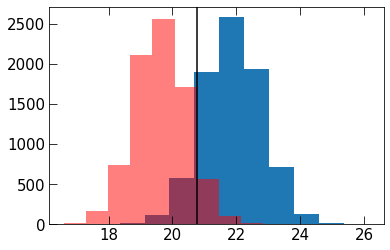

In [256]:
pl.hist(trace_C_aqua[0])
pl.hist(trace_C_swf[0], color='r', alpha=0.5)
pl.axvline(x=mean_common_time_ser_phytoC.iloc[0, 0], color='k');

In [257]:
mean_common_time_ser_phytoC.iloc[0]

mean_phyto_C     20.774066
sensor_fusion    20.654132
Name: 2002-07-15 00:00:00, dtype: float64

In [258]:
mean_common_time_ser_phytoC.to_pickle('./pklJar/df_mean_common_TS_phytoC.pkl')